# Practicum 4: Supply I - Enhancing the model

We will continue our modeling exercise by adding investment to the model.

This will allow us to discuss the rationale for how electricity markets work and to consider the policy impacts of alternative energy transition policies.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries, same as last session.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import *

Remember to set your path correctly:

In [18]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day4/practicum/"

## Building the model

We load the same data as last week, and also clean it up to simplify it further and create the demand and import curves.

In [ ]:
def load_and_prepare(dirpath: str):

    dfclust = pd.read_csv(f"{dirpath}/data_jaere_clustered.csv")
    tech = pd.read_csv(f"{dirpath}/data_technology.csv")

    # Re-scaling weights: multiply by 8.76 and normalize (so that we can interpret it as annual revenue in million USD)
    dfclust["weights"] = 8.76 * dfclust["weights"] / dfclust["weights"].sum()

    # One demand type (sum of components)
    dfclust["demand"] = (
        dfclust["q_residential"] + dfclust["q_commercial"] + dfclust["q_industrial"]
    )

    # Calibrate demand curve: demand = a - b * price
    elas = np.array([0.1, 0.2, 0.5, 0.3])
    dfclust["b"] = elas[0] * dfclust["demand"] / dfclust["price"]
    dfclust["b"] = dfclust["b"].mean()  # constant slope across t
    dfclust["a"] = dfclust["demand"] + dfclust["b"] * dfclust["price"]

    # Calibrate imports: imports = am + bm * price
    dfclust["bm"] = elas[3] * dfclust["imports"] / dfclust["price"]
    dfclust["am"] = dfclust["imports"] - dfclust["bm"] * dfclust["price"]

    # Set index names for tech
    tech.index = ["hydronuc","gas1","gas2","gas3","newgas","wind","solar"]
    
    # Annualization factor and fixed costs
    afactor = (1 - (1 / (1.05**20.0))) / 0.05
    tech["F"]  = tech["F"]  / afactor

    return dfclust, tech

dfclust, tech = load_and_prepare(dirpath)

In [4]:
tech

,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2
hydronuc,Hydro/Nuclear,10.000000,0.000000,0.000000,1.000,1.000,0,0,0,0,0.000000,0.000000,10.000000,0.000000
gas1,Existing 1,6.671990,0.092912,0.000000,7.500,11.500,0,0,0,1,0.360184,0.004886,23.351965,0.325193
gas2,Existing 2,9.794118,0.286247,0.000000,10.500,14.500,0,0,0,1,0.546134,0.011078,34.279413,1.001866
gas3,Existing 3,13.818120,20.535160,0.000000,0.578,0.578,0,0,0,1,0.816768,0.234476,48.363420,71.873060
newgas,New Gas,6.600000,0.000000,78.477250,0.000,100.000,1,0,0,1,0.350000,0.000000,23.351965,0.325193
wind,Wind,0.000000,0.000000,100.303234,0.000,100.000,1,1,0,0,0.000000,0.000000,0.000000,0.000000
solar,Solar,0.000000,0.000000,100.303234,0.000,100.000,1,1,1,0,0.000000,0.000000,0.000000,0.000000


In [5]:
TECHS = ["hydronuc","gas1","gas2","gas3","newgas","wind","solar"]
INV_TECHS = ["newgas","wind","solar"]

## 1) Adding investment solving "by hand"

This will update the code to compute profits. Here we will focus on natural gas investment but one can add any profit. 

Other than that, we will be solving the model as if investment is already chosen, those not adding any additional complication to the social planner problem.

In [20]:

def clear_market_profit(data, tech, wind_gw=0.0, solar_gw=0.0, gas_gw=0.0, ng_price=3.5, solver_name="ipopt"):
    """
    Welfare max (NLP) without solving for optimal investment
    """
    T = len(data)

    # plain python lookups (no Params)
    c = {k: float(tech.at[k, "c"]) for k in TECHS}
    if "heatrate" in tech.columns:
        for k in ["gas1","gas2","gas3","newgas"]:
            if k in tech.index:
                c[k] = float(tech.at[k, "heatrate"]) * float(ng_price)

    F = {k: float(tech.at[k, "F"]) for k in TECHS} if "F" in tech.columns else {k: 0.0 for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3"] if "capUB" in tech.columns and k in tech.index}

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.I = Set(initialize=TECHS, ordered=False)

    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, domain=Reals)
    m.imports = Var(m.T, domain=Reals)

    m.q = Var(m.T, m.I, domain=NonNegativeReals)
    m.costs = Var(m.T, domain=Reals)
    m.gs    = Var(m.T, domain=Reals)  # gross surplus

    # Objective: sum_t w_t * (gross_surplus_t - costs_t)
    m.obj = Objective(expr=sum(data.weights[t] * (m.gs[t] - m.costs[t]) for t in m.T), sense=maximize)

    # Market clearing
    m.demand_curve  = Constraint(m.T, expr={t: m.demand[t]  == data.a[t]  - data.b[t]  * m.price[t] for t in m.T})
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: m.demand[t]  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # Define surplus and costs
    m.surplus_def = Constraint(
        m.T,
        expr={t: m.gs[t] == (data.a[t] - m.demand[t]) * m.demand[t] / data.b[t] + (m.demand[t]**2) / (2.0 * data.b[t])
              for t in m.T}
    )
    m.cost_def = Constraint(
        m.T,
        expr={t: m.costs[t] == sum(c[k] * m.q[t,k] for k in m.I) + (m.imports[t] - data.am[t])**2 / (2.0 * data.bm[t])
              for t in m.T}
    )

    # Capacity constraints (as in Julia, but with TECHS names)
    m.cap_hydronuc = Constraint(m.T, expr={t: m.q[t,"hydronuc"] <= data.hydronuc[t] for t in m.T})
    if capUB:
        m.cap_gas123 = Constraint(m.T, Set(initialize=list(capUB)),
                                  expr={(t,k): m.q[t,k] <= capUB[k] for t in m.T for k in capUB})
    m.cap_newgas = Constraint(m.T, expr={t: m.q[t,"newgas"] <= float(gas_gw) for t in m.T})
    m.cap_wind   = Constraint(m.T, expr={t: m.q[t,"wind"]   <= float(wind_gw)  * data.wind_cap[t]  for t in m.T})
    m.cap_solar  = Constraint(m.T, expr={t: m.q[t,"solar"]  <= float(solar_gw) * data.solar_cap[t] for t in m.T})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term.lower() in ("optimal", "locallyoptimal", "locally_optimal", "locally optimal"):
        price   = np.array([value(m.price[t])   for t in m.T])
        demand  = np.array([value(m.demand[t])  for t in m.T])
        imports = np.array([value(m.imports[t]) for t in m.T])
        q = {k: np.array([value(m.q[t,k]) for t in m.T]) for k in TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr)/np.sum(w_arr))

        # cost accounting (matches Julia)
        cost = float(np.sum(w_arr * (sum(c[k] * q[k] for k in TECHS) + (imports - data["am"].to_numpy())**2 / (2.0 * data["bm"].to_numpy()))))

        # welfare/surplus (Julia subtracts fixed costs outside objective)
        surplus = float(np.sum([data.weights[t] * (value(m.gs[t]) - value(m.costs[t])) for t in m.T])
                        - F.get("newgas", 0.0) * float(gas_gw)
                        - F.get("wind",   0.0) * float(wind_gw)
                        - F.get("solar",  0.0) * float(solar_gw))

        profit_gas = (None if gas_gw == 0 else
                      float(np.sum([data.weights[t] * (price[t] - c["newgas"]) * q["newgas"][t] / float(gas_gw) for t in range(T)]) - F.get("newgas", 0.0)))
        profit_wind = float(np.sum([data.weights[t] * (price[t] - c["wind"]) * data.wind_cap[t] for t in range(T)]) - F.get("wind", 0.0))
        profit_solar = float(np.sum([data.weights[t] * (price[t] - c["solar"]) * data.solar_cap[t] for t in range(T)]) - F.get("solar", 0.0))

        return {
            "status": term,
            "avg_price": avg_price,
            "price": price,
            "quantity": q,      # dict: tech -> (T,) array
            "imports": imports,
            "demand": demand,
            "cost": cost,
            "profit_gas": profit_gas,
            "profit_wind": profit_wind,
            "profit_solar": profit_solar,
            "surplus": surplus,
        }

    return {"status": term}


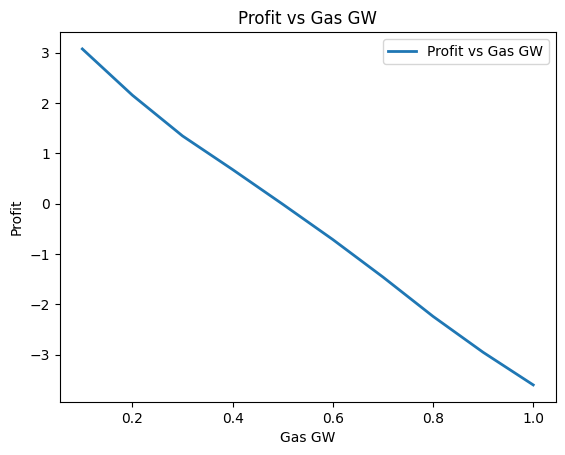

In [21]:
gas_grid = np.arange(0.0, 1.0 + 1e-9, 0.1)   # 0.0:0.25:5.0 in Julia

profits = np.array([
    clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["profit_gas"]
    for g in gas_grid
], dtype=float)

plt.figure()
plt.plot(gas_grid, profits, lw=2, label="Profit vs Gas GW")
plt.xlabel("Gas GW")
plt.ylabel("Profit")
plt.title("Profit vs Gas GW")
plt.legend(loc="upper right")
plt.show()

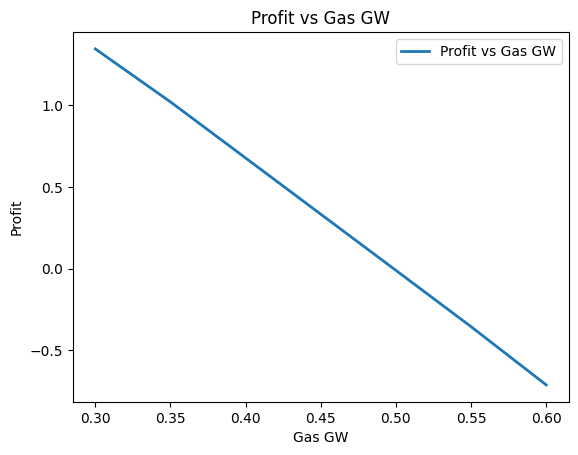

In [8]:
gas_grid = np.arange(0.3, 0.6 + 1e-9, 0.05)
profits = np.array([clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["profit_gas"] for g in gas_grid], dtype=float)
plt.figure()
plt.plot(gas_grid, profits, lw=2, label="Profit vs Gas GW")
plt.xlabel("Gas GW")
plt.ylabel("Profit")
plt.title("Profit vs Gas GW")
plt.legend(loc="upper right")
plt.show()

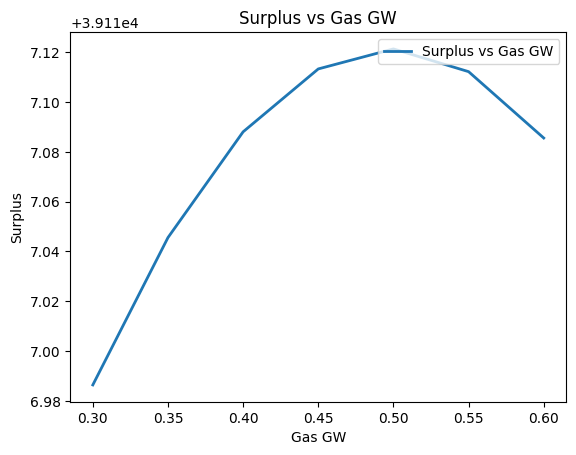

In [22]:
# This is where surplus is maximized! (competitive equilibrium)
gas_grid = np.arange(0.3, 0.6 + 1e-9, 0.05)
surplus = np.array([clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["surplus"] for g in gas_grid], dtype=float)
plt.figure()
plt.plot(gas_grid, surplus, lw=2, label="Surplus vs Gas GW")
plt.xlabel("Gas GW")
plt.ylabel("Surplus")
plt.title("Surplus vs Gas GW")
plt.legend(loc="upper right")
plt.show()

## 2) Adding investment with social planner

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs - Fixed Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

Notice that we added the fixed costs to the problem, as we will be solving for the optimal level of wind and solar investment.

In [23]:
def clear_market_invest(data, tech, ng_price=3.5, tax=50.0, Kmax=50.0, data_center_factor=0.0, solver_name="ipopt"):
    """
    Welfare max with endogenous investment (NLP)
    """
    T = len(data)

    # plain python lookups (no Params)
    c = {k: float(tech.at[k, "c"]) for k in TECHS}
    if "heatrate" in tech.columns:
        for k in ["gas1","gas2","gas3","newgas"]:
            if k in tech.index:
                c[k] = float(tech.at[k, "heatrate"]) * float(ng_price)

    e = {k: float(tech.at[k, "e"]) for k in TECHS} if "e" in tech.columns else {k: 0.0 for k in TECHS}
    F = {k: float(tech.at[k, "F"]) for k in TECHS} if "F" in tech.columns else {k: 0.0 for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3"] if "capUB" in tech.columns and k in tech.index}

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.I = Set(initialize=TECHS, ordered=False)
    m.J = Set(initialize=INV_TECHS, ordered=False)

    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, domain=Reals)
    m.imports = Var(m.T, domain=Reals)

    m.q     = Var(m.T, m.I, domain=NonNegativeReals)
    m.costs = Var(m.T, domain=Reals)
    m.gs    = Var(m.T, domain=Reals)

    m.K      = Var(m.J, bounds=(0.0, float(Kmax)))  # capacity investments

    # Objective: gross surplus - variable costs - fixed costs
    m.obj = Objective(
        expr=sum(data.weights[t] * (m.gs[t] - m.costs[t]) for t in m.T)
             - sum(F.get(k) * m.K[k] for k in m.J),
        sense=maximize
    )

    # Market clearing
    m.demand_curve  = Constraint(m.T, expr={t: m.demand[t]  == data.a[t] + data_center_factor * np.mean(data.demand)  - data.b[t]  * m.price[t] for t in m.T})
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: m.demand[t]  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # Surplus + costs
    m.surplus_def = Constraint(
        m.T,
        expr={t: m.gs[t] == (data.a[t] + data_center_factor * np.mean(data.demand) - m.demand[t]) * m.demand[t] / data.b[t] + (m.demand[t]**2) / (2.0 * data.b[t])
              for t in m.T}
    )
    m.cost_def = Constraint(
        m.T,
        expr={t: m.costs[t] == sum((c[k] + float(tax) * e[k]) * m.q[t,k] for k in m.I)
                           + (m.imports[t] - data.am[t])**2 / (2.0 * data.bm[t])
              for t in m.T}
    )

    # Capacity constraints
    m.cap_hydronuc = Constraint(m.T, expr={t: m.q[t,"hydronuc"] <= data.hydronuc[t] for t in m.T})
    if capUB:
        m.cap_gas123 = Constraint(m.T, Set(initialize=list(capUB)),
                                  expr={(t,k): m.q[t,k] <= capUB[k] for t in m.T for k in capUB})

    m.cap_newgas = Constraint(m.T, expr={t: m.q[t,"newgas"] <= m.K["newgas"] for t in m.T})
    m.cap_wind   = Constraint(m.T, expr={t: m.q[t,"wind"]   <= m.K["wind"]  * data.wind_cap[t]  for t in m.T})
    m.cap_solar  = Constraint(m.T, expr={t: m.q[t,"solar"]  <= m.K["solar"] * data.solar_cap[t] for t in m.T})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term.lower() in ("optimal", "locallyoptimal", "locally_optimal", "locally optimal"):
        price   = np.array([value(m.price[t])   for t in m.T])
        demand  = np.array([value(m.demand[t])  for t in m.T])
        imports = np.array([value(m.imports[t]) for t in m.T])
        q = {k: np.array([value(m.q[t,k]) for t in m.T]) for k in TECHS}
        K = {k: float(value(m.K[k]))           for k in INV_TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr) / np.sum(w_arr))

        cost = np.array([value(m.costs[t]) for t in m.T])

        profit_gas = float(np.sum([data.weights[t] * (price[t] - c["newgas"]) * q["newgas"][t] for t in range(T)])
                           - F.get("newgas", 0.0) * K["newgas"])

        surplus = float(np.sum([data.weights[t] * (value(m.gs[t]) - value(m.costs[t])) for t in m.T])
                        - F.get("newgas", 0.0) * K["newgas"]
                        - F.get("wind",   0.0) * K["wind"]
                        - F.get("solar",  0.0) * K["solar"])

        return {
            "status": term,
            "avg_price": avg_price,
            "price": price,
            "quantity": q,   # dict: tech -> (T,) array
            "imports": imports,
            "demand": demand,
            "cost": cost,    # (T,) array (like Julia costs[t])
            "K": K,
            "profit_gas": profit_gas,
            "surplus": surplus,
        }

    return {"status": term}


In [24]:
results = clear_market_invest(dfclust, tech, ng_price=3.5, tax=0.0)
print("Investment SP:", results["status"], "avg_price:", results.get("avg_price"), "K:", results.get("K"))

Investment SP: optimal avg_price: 31.96443239670289 K: {'newgas': 0.4983285298502584, 'wind': -8.524553279176704e-09, 'solar': -9.935825124462346e-09}


In [33]:
results = clear_market_invest(dfclust, tech, ng_price=3.5, tax=50.0)
print("Investment SP:", results["status"], "avg_price:", results.get("avg_price"), "K:", results.get("K"))

Investment SP: optimal avg_price: 39.35908765296707 K: {'newgas': -9.972562410791536e-09, 'wind': 26.05734503353563, 'solar': -9.965667338463989e-09}


In [25]:
results = clear_market_invest(dfclust, tech, ng_price=3.5, data_center_factor=0.5, tax=0.0)
print("Investment SP:", results["status"], "avg_price:", results.get("avg_price"), "K:", results.get("K"))

Investment SP: optimal avg_price: 32.02891390286472 K: {'newgas': 14.573794223524397, 'wind': -8.025198494408785e-09, 'solar': -9.935695001793424e-09}


In [28]:
results = clear_market_invest(dfclust, tech, ng_price=3.5, data_center_factor=0.5, tax=100.0, Kmax=30.0,)
print("Investment SP:", results["status"], "avg_price:", results.get("avg_price"), "K:", results.get("K"))

Investment SP: optimal avg_price: 65.65756264309195 K: {'newgas': 3.3460400573051556, 'wind': 30.00000029996618, 'solar': 17.46949749577185}


## 3) Adding investment with integer variables

We modify our mixed integer code with an additional "dummy" variable that allows for a corner solution at zero investment. If at zero investment firms make no money, then the zero profit condition is negative. Otherwise, the zero profit condition must be zero.

In [29]:
def clear_market_foc(data, tech, ng_price=3.5, tax=50.0, M=1e4, Kmax=50.0, solver_name="highs"):
    """
    FOC-based equilibrium with investment (MILP), JuMP -> Pyomo.
    """
    T = len(data)

    # plain python lookups (no Params)
    c = {k: float(tech.at[k, "c"]) for k in TECHS}
    if "heatrate" in tech.columns:
        for k in ["gas1","gas2","gas3","newgas"]:
            if k in tech.index:
                c[k] = float(tech.at[k, "heatrate"]) * float(ng_price)

    e = {k: float(tech.at[k, "e"]) for k in TECHS}
    F = {k: float(tech.at[k, "F"]) for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3"]}

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.I = Set(initialize=TECHS, ordered=False)
    m.J = Set(initialize=INV_TECHS, ordered=False)

    # vars
    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, domain=Reals)
    m.imports = Var(m.T, domain=Reals)

    m.q      = Var(m.T, m.I, domain=NonNegativeReals)
    m.shadow = Var(m.T, m.I, domain=NonNegativeReals)

    m.K      = Var(m.J, bounds=(0.0, float(Kmax)))  # capacity
    m.profit = Var(m.J, domain=Reals)

    m.u1 = Var(m.T, m.I, domain=Binary)  # used
    m.u2 = Var(m.T, m.I, domain=Binary)  # at cap
    m.u3 = Var(m.J, domain=Binary)       # built

    # objective: minimize weighted avg price
    m.obj = Objective(expr=sum(m.price[t] * data.weights[t] for t in m.T), sense=minimize)

    # market clearing
    m.demand_curve  = Constraint(m.T, expr={t: m.demand[t]  == data.a[t]  - data.b[t]  * m.price[t] for t in m.T})
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: m.demand[t]  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # capacity upper bounds (u1 gates usage)
    m.ub_hyd = Constraint(m.T, expr={t: m.q[t,"hydronuc"] <= m.u1[t,"hydronuc"] * data.hydronuc[t] for t in m.T})
    if capUB:
        m.ub_gas123 = Constraint(m.T, Set(initialize=list(capUB)),
                                 expr={(t,k): m.q[t,k] <= m.u1[t,k] * capUB[k] for t in m.T for k in capUB})
    m.ub_rest = Constraint(m.T, Set(initialize=["newgas","wind","solar"]),
                           expr={(t,k): m.q[t,k] <= m.u1[t,k] * Kmax for t in m.T for k in ["newgas","wind","solar"]})

    # link dispatch to installed capacity (K)
    m.ub_newgas = Constraint(m.T, expr={t: m.q[t,"newgas"] <= m.K["newgas"] for t in m.T})
    m.ub_wind   = Constraint(m.T, expr={t: m.q[t,"wind"]   <= m.K["wind"]  * data.wind_cap[t]  for t in m.T})
    m.ub_solar  = Constraint(m.T, expr={t: m.q[t,"solar"]  <= m.K["solar"] * data.solar_cap[t] for t in m.T})

    # capacity lower bounds (u2 indicates “at capacity”)
    m.lb_hyd = Constraint(m.T, expr={t: m.q[t,"hydronuc"] >= m.u2[t,"hydronuc"] * data.hydronuc[t] for t in m.T})
    if capUB:
        m.lb_gas123 = Constraint(m.T, Set(initialize=list(capUB)),
                                 expr={(t,k): m.q[t,k] >= m.u2[t,k] * capUB[k] for t in m.T for k in capUB})

    m.lb_newgas = Constraint(m.T, expr={t: m.q[t,"newgas"] >= m.K["newgas"] - float(M) * (1 - m.u2[t,"newgas"]) for t in m.T})
    m.lb_wind   = Constraint(m.T, expr={t: m.q[t,"wind"]   >= m.K["wind"]  * data.wind_cap[t]  - float(M) * (1 - m.u2[t,"wind"])  for t in m.T})
    m.lb_solar  = Constraint(m.T, expr={t: m.q[t,"solar"]  >= m.K["solar"] * data.solar_cap[t] - float(M) * (1 - m.u2[t,"solar"]) for t in m.T})

    m.u_link = Constraint(m.T, m.I, expr={(t,k): m.u1[t,k] >= m.u2[t,k] for t in m.T for k in m.I})

    # optimality constraints (KKT envelope with big-M)
    m.foc_lb = Constraint(
        m.T, m.I,
        expr={(t,k): (m.price[t] - c[k] - float(tax) * e[k] - m.shadow[t,k]) >= -float(M) * (1 - m.u1[t,k])
              for t in m.T for k in m.I}
    )
    m.foc_ub = Constraint(
        m.T, m.I,
        expr={(t,k): (m.price[t] - c[k] - float(tax) * e[k] - m.shadow[t,k]) <= 0.0
              for t in m.T for k in m.I}
    )
    m.shadow_cap = Constraint(m.T, m.I, expr={(t,k): m.shadow[t,k] <= float(M) * m.u2[t,k] for t in m.T for k in m.I})

    # profits (only for investable techs)
    m.profit_newgas = Constraint(expr=m.profit["newgas"] == sum(data.weights[t] * m.shadow[t,"newgas"] for t in m.T) - F.get("newgas", 0.0))
    m.profit_wind   = Constraint(expr=m.profit["wind"]   == sum(data.weights[t] * m.shadow[t,"wind"]  * data.wind_cap[t]  for t in m.T) - F.get("wind", 0.0))
    m.profit_solar  = Constraint(expr=m.profit["solar"]  == sum(data.weights[t] * m.shadow[t,"solar"] * data.solar_cap[t] for t in m.T) - F.get("solar", 0.0))

    # investment constraints (zero-profit logic)
    m.zp_ub = Constraint(m.J, expr={k: m.profit[k] <= 0.0 for k in m.J})
    m.zp_lb = Constraint(m.J, expr={k: m.profit[k] >= -float(M) * (1 - m.u3[k]) for k in m.J})
    m.K_link = Constraint(m.J, expr={k: m.K[k] <= float(M) * m.u3[k] for k in m.J})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term == "optimal":
        price   = np.array([value(m.price[t])   for t in m.T])
        demand  = np.array([value(m.demand[t])  for t in m.T])
        imports = np.array([value(m.imports[t]) for t in m.T])
        q       = {k: np.array([value(m.q[t,k])      for t in m.T]) for k in TECHS}
        shadow  = {k: np.array([value(m.shadow[t,k]) for t in m.T]) for k in TECHS}
        u1      = {k: np.array([value(m.u1[t,k])     for t in m.T]) for k in TECHS}
        u2      = {k: np.array([value(m.u2[t,k])     for t in m.T]) for k in TECHS}
        K       = {k: float(value(m.K[k]))           for k in INV_TECHS}
        profit  = {k: float(value(m.profit[k]))      for k in INV_TECHS}
        u3      = {k: int(round(value(m.u3[k])))     for k in INV_TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr)/np.sum(w_arr))

        # cost accounting (same as Julia 'cost' line: gen + import quad; no tax term there)
        gen_cost_t = sum(c[k] * q[k] for k in TECHS)
        imp_cost_t = (imports - data["am"].to_numpy()) ** 2 / (2.0 * data["bm"].to_numpy())
        total_cost = float(np.sum(w_arr * (gen_cost_t + imp_cost_t)))

        return {"status": term, "avg_price": avg_price, "price": price, "quantity": q, "imports": imports,
                "demand": demand, "cost": total_cost, "shadow": shadow, "K": K, "profit": profit, "u1": u1, "u2": u2, "u3": u3}

    return {"status": term}


In [30]:
invest_foc = clear_market_foc(dfclust, tech, ng_price=3.5, tax=0.0)
print("Investment FOC:", invest_foc["status"], "avg_price:", invest_foc.get("avg_price"), "K:", invest_foc.get("K"))

Investment FOC: optimal avg_price: 31.96443245481713 K: {'newgas': 0.4983286123096695, 'wind': 0.0, 'solar': 0.0}


In [31]:
invest_foc_tax = clear_market_foc(dfclust, tech, ng_price=3.5, tax=50.0)
print("Investment FOC w/ tax:", invest_foc_tax["status"], "avg_price:", invest_foc_tax.get("avg_price"), "K:", invest_foc_tax.get("K"))

Investment FOC w/ tax: optimal avg_price: 39.359087726718855 K: {'newgas': 0.0, 'wind': 26.05734517740299, 'solar': 0.0}


## Exercise 1

Add carbon taxes to the model. Note that emissions are equal to the emissions rate times the quantity. The cost should be equal to the tax. (in class)

## Exercise 2

Add a subsidy to the model. One can think of the subsidy as a negative cost to renewable power. However, it is important that you also include a penalty to the overall subsidy spending of you want to get at the overall welfare. Important however to solve the model first without worrying about where the subsidy money comes from. Otherwise, the planner will see that a subsidy is distorting outcomes.

## Follow-up exercises

1. Consider a tax and a subsidy that reach the same target of emissions. What are the costs of each policy? How are the different technologies and components of welfare affected? [Note: This will require you to include emissions as an input or an output to the function.]